In [1]:
!pip install -Uqq duckduckgo_search

In [5]:
!pip install ipywidgets widgetsnbextension pandas-profiling

In [1]:
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastai.vision.all import *

def search_images(term, max_images=200): return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [18]:
# Get training images
class_a_name = 'spoon'
noise_name = 'pile of junk'
class_a_searches = [f"{class_a_name} photo", f"{class_a_name} box photo", f"{class_a_name} table photo"]
noise_searches = [f"{noise_name} photo", f"{noise_name} table photo", f"{noise_name} closet photo"]
searches = {class_a_name: class_a_searches, "noise": noise_searches}
path = Path(f"{class_a_name}_or_not")

In [19]:
from time import sleep
for k,v in searches.items():
    dest = (path/k)
    dest.mkdir(exist_ok=True, parents=True)
    for o in v:
        print(f"searching {o}")
        download_images(dest, urls=search_images(o))
        print("done – sleeping ...")
        sleep(5)
    resize_images(path/k, max_size=400, dest=path/k)

searching spoon photo
done – sleeping ...
searching spoon box photo
done – sleeping ...
searching spoon table photo
done – sleeping ...


/home/py/workspace/fastai/venv/lib/python3.10/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


searching pile of junk photo
done – sleeping ...
searching pile of junk table photo
done – sleeping ...
searching pile of junk closet photo
done – sleeping ...


/home/py/workspace/fastai/venv/lib/python3.10/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [20]:
# Clean data
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

22

In [21]:
# Train model
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,0.690545,0.162745,0.065789,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.183372,0.144428,0.057018,00:02
1,0.103267,0.175207,0.057018,00:02
2,0.064359,0.167213,0.057018,00:02
3,0.045690,0.156603,0.043860,00:02
4,0.035421,0.154794,0.052632,00:02


In [14]:
is_bird,_,probs = learn.predict(PILImage.create('test_bird.jpeg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {float(probs[0]):.4f}")

This is a: bird.
0.9999998807907104
Probability it's a bird: 1.0000


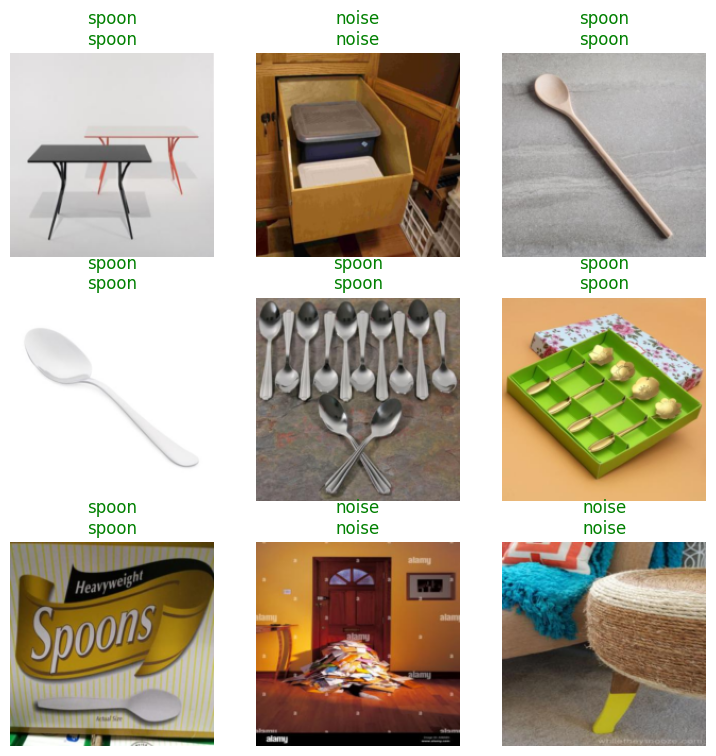

In [24]:
learn.show_results()